In [1]:
import os
import re
import string
from typing import List, Tuple, Dict
from collections import Counter
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
def read_data(file_path: str) -> List[str]:
    """Đọc file txt và trả về list sentences (theo lines để giữ parallel)."""
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File {file_path} không tồn tại. Tải từ VLSP hoặc IWSLT.")
    
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = [line.strip() for line in f if line.strip() and not line.startswith('(truncated')]
    
    return lines

train_src_path = 'public_test.vi.txt' 
train_tgt_path = 'public_test.en.txt'  
train_src = read_data(train_src_path)
train_tgt = read_data(train_tgt_path)

if len(train_src) != len(train_tgt):
    raise ValueError(f"Số sentences không khớp! Src: {len(train_src)}, Tgt: {len(train_tgt)}")

test_src = train_src[:int(0.2 * len(train_src))]  # Ví dụ split 20% cho test
test_tgt = train_tgt[:int(0.2 * len(train_tgt))]

# Báo cáo thống kê
print(f"Số sentences train: {len(train_src)} (src Vi), {len(train_tgt)} (tgt En)")
print(f"Số sentences test: {len(test_src)}")
print("Ví dụ sentence src (Vi):", train_src[0])
print("Ví dụ sentence tgt (En):", train_tgt[0])

Số sentences train: 3000 (src Vi), 3000 (tgt En)
Số sentences test: 600
Ví dụ sentence src (Vi): Thực trạng kiến thức và thực hành của người có thẻ bảo hiểm y tế trong sử dụng dịch vụ khám chữa bệnh ở các cơ sở y tế công và một số yếu tố ảnh hưởng tại tỉnh Viêng Chăn, CHDCND Lào, năm 2017
Ví dụ sentence tgt (En): Knowledge, practices in public health service utilization among health insurance card’s holders and influencing factors in Vientiane, Lao


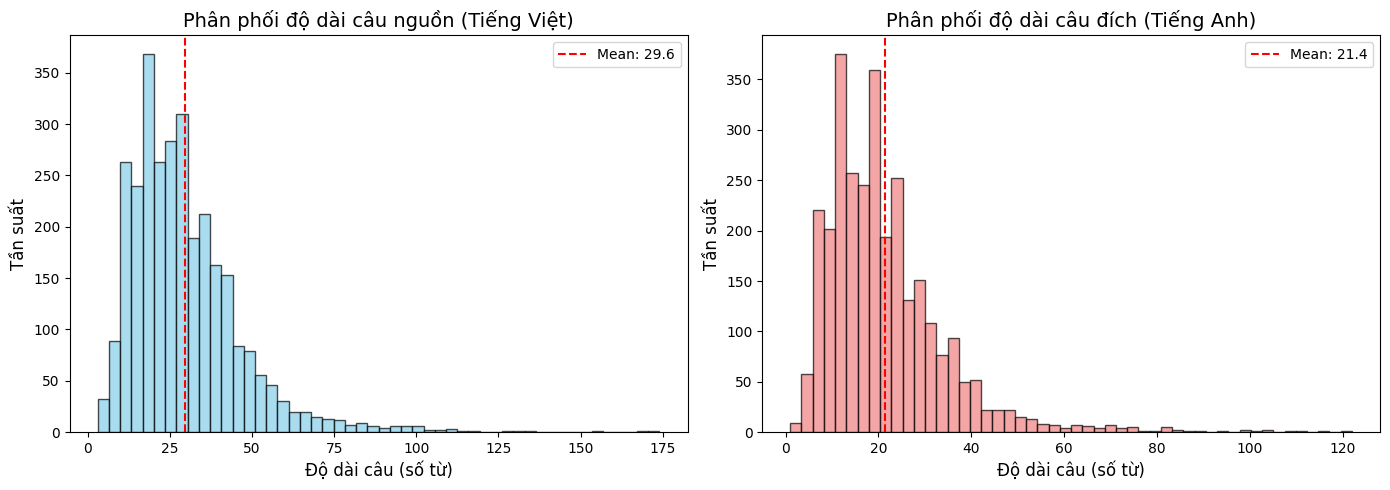

Min/Max src: 3/174
Min/Max tgt: 1/122


In [3]:
# Phân tích độ dài câu gốc (trước khi clean)
src_lengths = [len(s.split()) for s in train_src]
tgt_lengths = [len(t.split()) for t in train_tgt]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram cho source (Vietnamese)
axes[0].hist(src_lengths, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Độ dài câu (số từ)', fontsize=12)
axes[0].set_ylabel('Tần suất', fontsize=12)
axes[0].set_title('Phân phối độ dài câu nguồn (Tiếng Việt)', fontsize=14)
axes[0].axvline(x=sum(src_lengths)/len(src_lengths), color='red', linestyle='--', label=f'Mean: {sum(src_lengths)/len(src_lengths):.1f}')
axes[0].legend()

# Histogram cho target (English)
axes[1].hist(tgt_lengths, bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Độ dài câu (số từ)', fontsize=12)
axes[1].set_ylabel('Tần suất', fontsize=12)
axes[1].set_title('Phân phối độ dài câu đích (Tiếng Anh)', fontsize=14)
axes[1].axvline(x=sum(tgt_lengths)/len(tgt_lengths), color='red', linestyle='--', label=f'Mean: {sum(tgt_lengths)/len(tgt_lengths):.1f}')
axes[1].legend()

plt.tight_layout()
plt.savefig('length_distribution_raw.png', dpi=150)
plt.show()

print(f"Min/Max src: {min(src_lengths)}/{max(src_lengths)}")
print(f"Min/Max tgt: {min(tgt_lengths)}/{max(tgt_lengths)}")

In [4]:
def clean_sentence(sentence: str) -> str:
    """Làm sạch: lowercase, remove punctuation (giữ numbers cho y tế), strip spaces."""
    sentence = sentence.lower()
    # Không remove numbers: Chỉ remove punctuation
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    sentence = re.sub(r'\s+', ' ', sentence)  # Extra spaces
    return sentence.strip()

# Tạo pairs và clean
train_pairs = [(clean_sentence(src), clean_sentence(tgt)) for src, tgt in zip(train_src, train_tgt)]
test_pairs = [(clean_sentence(src), clean_sentence(tgt)) for src, tgt in zip(test_src, test_tgt)]

# Lọc sentences: min_len=3 words, max_len=100 words
min_len, max_len = 3, 100
train_pairs = [(src, tgt) for src, tgt in train_pairs if min_len <= len(src.split()) <= max_len and min_len <= len(tgt.split()) <= max_len]
test_pairs = [(src, tgt) for src, tgt in test_pairs if min_len <= len(src.split()) <= max_len and min_len <= len(tgt.split()) <= max_len]

# Báo cáo
avg_src_len = sum(len(s.split()) for s, _ in train_pairs) / len(train_pairs)
print(f"Số pairs train sau clean: {len(train_pairs)}. Độ dài trung bình src: {avg_src_len:.2f} words.")

Số pairs train sau clean: 2983. Độ dài trung bình src: 28.88 words.


C:\Users\HH\AppData\Local\Temp\ipykernel_25380\3782808822.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot([src_lengths_clean, tgt_lengths_clean], labels=['Vi', 'En'])


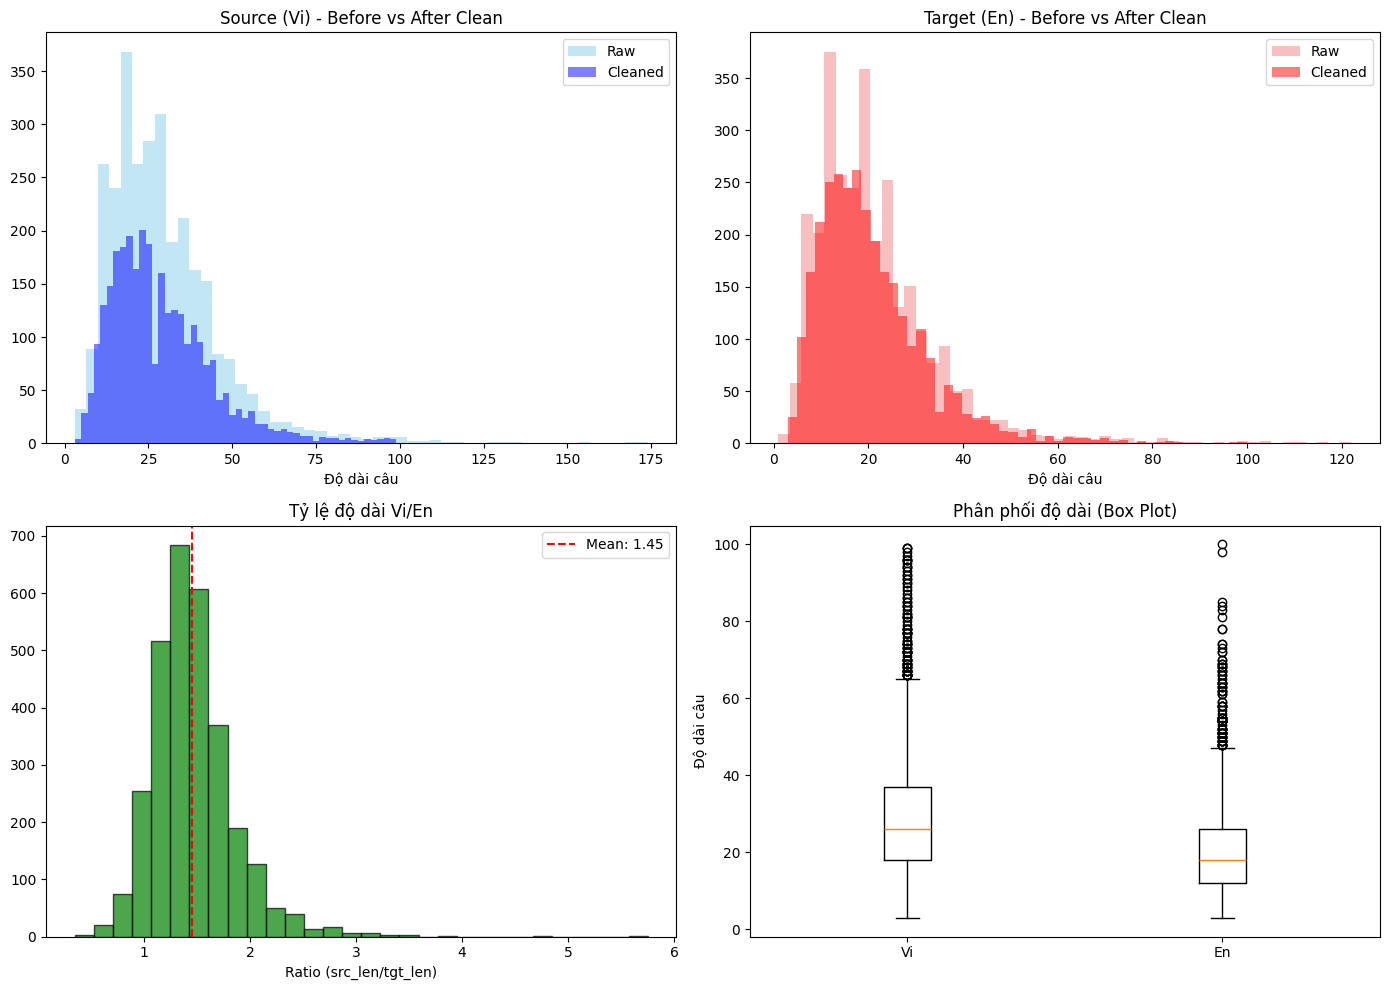

Số câu bị loại: 17 (0.6%)


In [5]:
# Phân phối sau khi clean và filter
src_lengths_clean = [len(s.split()) for s, _ in train_pairs]
tgt_lengths_clean = [len(t.split()) for _, t in train_pairs]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# So sánh source
axes[0, 0].hist(src_lengths, bins=50, color='skyblue', alpha=0.5, label='Raw')
axes[0, 0].hist(src_lengths_clean, bins=50, color='blue', alpha=0.5, label='Cleaned')
axes[0, 0].set_title('Source (Vi) - Before vs After Clean')
axes[0, 0].legend()
axes[0, 0].set_xlabel('Độ dài câu')

# So sánh target
axes[0, 1].hist(tgt_lengths, bins=50, color='lightcoral', alpha=0.5, label='Raw')
axes[0, 1].hist(tgt_lengths_clean, bins=50, color='red', alpha=0.5, label='Cleaned')
axes[0, 1].set_title('Target (En) - Before vs After Clean')
axes[0, 1].legend()
axes[0, 1].set_xlabel('Độ dài câu')

# Tỷ lệ độ dài src/tgt
length_ratios = [len(s.split())/len(t.split()) for s, t in train_pairs]
axes[1, 0].hist(length_ratios, bins=30, color='green', alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Tỷ lệ độ dài Vi/En')
axes[1, 0].set_xlabel('Ratio (src_len/tgt_len)')
axes[1, 0].axvline(x=sum(length_ratios)/len(length_ratios), color='red', linestyle='--', 
                    label=f'Mean: {sum(length_ratios)/len(length_ratios):.2f}')
axes[1, 0].legend()

# Box plot so sánh
axes[1, 1].boxplot([src_lengths_clean, tgt_lengths_clean], labels=['Vi', 'En'])
axes[1, 1].set_title('Phân phối độ dài (Box Plot)')
axes[1, 1].set_ylabel('Độ dài câu')

plt.tight_layout()
plt.savefig('length_distribution_cleaned.png', dpi=150)
plt.show()

print(f"Số câu bị loại: {len(train_src) - len(train_pairs)} ({100*(len(train_src)-len(train_pairs))/len(train_src):.1f}%)")

In [6]:
def tokenize(sentence: str) -> List[str]:
    """Tokenize: split words, thêm <SOS> và <EOS>."""
    tokens = sentence.split()
    return ['<SOS>'] + tokens + ['<EOS>']

# Tokenize tất cả
train_src_tokens = [tokenize(src) for src, _ in train_pairs]
train_tgt_tokens = [tokenize(tgt) for _, tgt in train_pairs]
test_src_tokens = [tokenize(src) for src, _ in test_pairs]
test_tgt_tokens = [tokenize(tgt) for _, tgt in test_pairs]

In [7]:
def build_vocab(tokens_list: List[List[str]], min_freq: int = 2) -> Dict[str, int]:
    """Build vocab from scratch: dict word -> index."""
    counter = Counter()
    for tokens in tokens_list:
        counter.update(tokens)
    
    specials = ['<PAD>', '<UNK>', '<SOS>', '<EOS>']  # Index 0-3
    vocab = {token: idx for idx, token in enumerate(specials)}
    
    for token, freq in counter.items():
        if freq >= min_freq and token not in vocab:
            vocab[token] = len(vocab)
    
    return vocab

# Build (bao gồm test để giảm OOV)
src_vocab = build_vocab(train_src_tokens + test_src_tokens)
tgt_vocab = build_vocab(train_tgt_tokens + test_tgt_tokens)

# Báo cáo
print(f"Vocab size src (Vi): {len(src_vocab)}. Từ phổ biến:", Counter(' '.join(train_src).split()).most_common(5))
print(f"Vocab size tgt (En): {len(tgt_vocab)}")

Vocab size src (Vi): 3139. Từ phổ biến: [('và', 1748), ('bệnh', 1380), ('có', 1245), ('là', 860), ('nhân', 824)]
Vocab size tgt (En): 5105


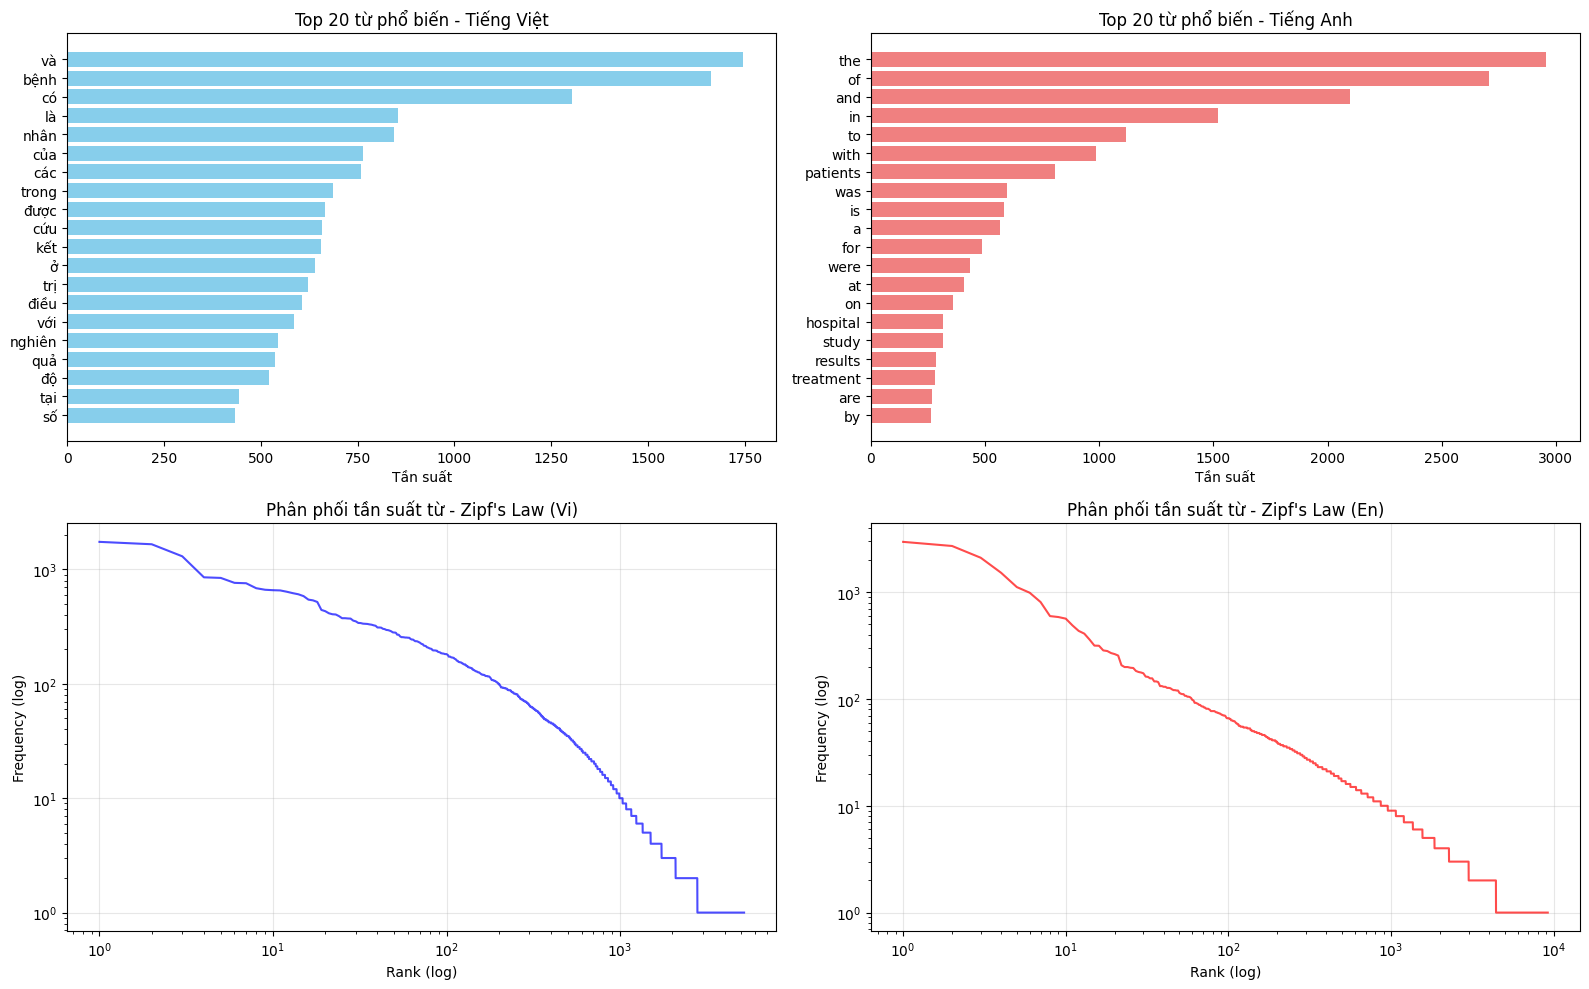


Vocab Coverage Analysis:
Số từ xuất hiện 1 lần (Vi): 2397 (46.3%)
Số từ xuất hiện 1 lần (En): 4786 (52.0%)
Số từ xuất hiện >=5 lần (Vi): 1498
Số từ xuất hiện >=5 lần (En): 1849


In [8]:
# Phân tích vocab
from collections import Counter

# Đếm tần suất từ trong corpus
src_word_freq = Counter()
for tokens in train_src_tokens:
    src_word_freq.update([t for t in tokens if t not in ['<SOS>', '<EOS>']])

tgt_word_freq = Counter()
for tokens in train_tgt_tokens:
    tgt_word_freq.update([t for t in tokens if t not in ['<SOS>', '<EOS>']])

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Top 20 từ phổ biến - Source
top_src = src_word_freq.most_common(20)
axes[0, 0].barh([w for w, _ in top_src][::-1], [c for _, c in top_src][::-1], color='skyblue')
axes[0, 0].set_title('Top 20 từ phổ biến - Tiếng Việt')
axes[0, 0].set_xlabel('Tần suất')

# Top 20 từ phổ biến - Target
top_tgt = tgt_word_freq.most_common(20)
axes[0, 1].barh([w for w, _ in top_tgt][::-1], [c for _, c in top_tgt][::-1], color='lightcoral')
axes[0, 1].set_title('Top 20 từ phổ biến - Tiếng Anh')
axes[0, 1].set_xlabel('Tần suất')

# Phân phối tần suất từ (log scale)
src_freqs = sorted(src_word_freq.values(), reverse=True)
tgt_freqs = sorted(tgt_word_freq.values(), reverse=True)

axes[1, 0].plot(range(1, len(src_freqs)+1), src_freqs, color='blue', alpha=0.7, label='Vi')
axes[1, 0].set_xscale('log')
axes[1, 0].set_yscale('log')
axes[1, 0].set_title('Phân phối tần suất từ - Zipf\'s Law (Vi)')
axes[1, 0].set_xlabel('Rank (log)')
axes[1, 0].set_ylabel('Frequency (log)')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(range(1, len(tgt_freqs)+1), tgt_freqs, color='red', alpha=0.7, label='En')
axes[1, 1].set_xscale('log')
axes[1, 1].set_yscale('log')
axes[1, 1].set_title('Phân phối tần suất từ - Zipf\'s Law (En)')
axes[1, 1].set_xlabel('Rank (log)')
axes[1, 1].set_ylabel('Frequency (log)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('vocab_distribution.png', dpi=150)
plt.show()

# Báo cáo vocab coverage
print(f"\nVocab Coverage Analysis:")
print(f"Số từ xuất hiện 1 lần (Vi): {sum(1 for f in src_word_freq.values() if f == 1)} ({sum(1 for f in src_word_freq.values() if f == 1)/len(src_word_freq)*100:.1f}%)")
print(f"Số từ xuất hiện 1 lần (En): {sum(1 for f in tgt_word_freq.values() if f == 1)} ({sum(1 for f in tgt_word_freq.values() if f == 1)/len(tgt_word_freq)*100:.1f}%)")
print(f"Số từ xuất hiện >=5 lần (Vi): {sum(1 for f in src_word_freq.values() if f >= 5)}")
print(f"Số từ xuất hiện >=5 lần (En): {sum(1 for f in tgt_word_freq.values() if f >= 5)}")

In [9]:
def tokens_to_indices(tokens: List[str], vocab: Dict[str, int]) -> torch.Tensor:
    """Chuyển tokens thành tensor indices, dùng <UNK> nếu unknown."""
    unk_idx = vocab.get('<UNK>', 1)
    indices = [vocab.get(token, unk_idx) for token in tokens]
    return torch.tensor(indices, dtype=torch.long)

max_seq_len = 128  # Tùy chỉnh dựa trên dữ liệu

def pad_truncate_sequences(tokens_list: List[List[str]], vocab: Dict[str, int]) -> torch.Tensor:
    """Truncate và pad sequences thành tensor."""
    indices_list = []
    for tokens in tokens_list:
        if len(tokens) > max_seq_len:
            tokens = tokens[:max_seq_len]  # Truncate
        indices = tokens_to_indices(tokens, vocab)
        indices_list.append(indices)
    
    # Pad với <PAD> (0)
    padded = torch.nn.utils.rnn.pad_sequence(indices_list, batch_first=True, padding_value=vocab['<PAD>'])
    return padded

# Áp dụng
train_src_indices = pad_truncate_sequences(train_src_tokens, src_vocab)
train_tgt_indices = pad_truncate_sequences(train_tgt_tokens, tgt_vocab)
test_src_indices = pad_truncate_sequences(test_src_tokens, src_vocab)
test_tgt_indices = pad_truncate_sequences(test_tgt_tokens, tgt_vocab)

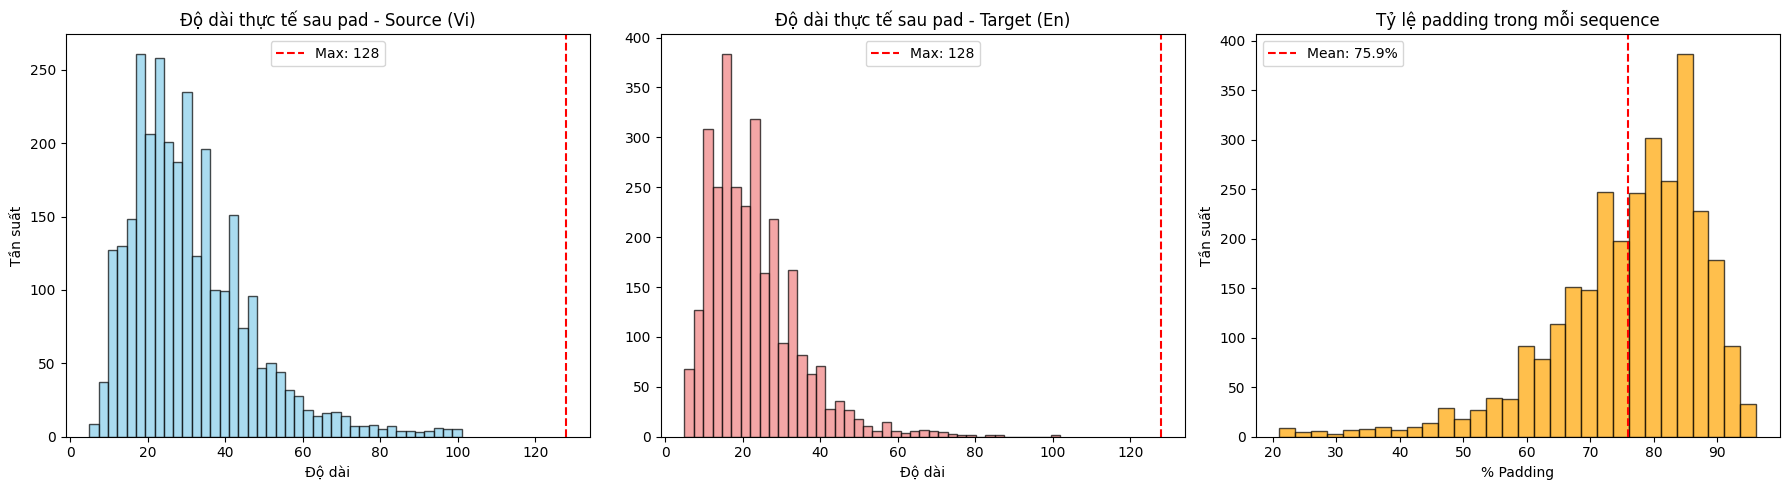

Số câu bị truncate (Vi): 0
Số câu bị truncate (En): 0
Tỷ lệ padding trung bình: 75.9%


In [10]:
# Phân tích sau khi pad/truncate
def get_actual_lengths(padded_tensor, pad_idx=0):
    """Tính độ dài thực (không tính padding)"""
    return [(row != pad_idx).sum().item() for row in padded_tensor]

train_src_actual_lens = get_actual_lengths(train_src_indices)
train_tgt_actual_lens = get_actual_lengths(train_tgt_indices)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram độ dài thực tế
axes[0].hist(train_src_actual_lens, bins=40, color='skyblue', alpha=0.7, edgecolor='black')
axes[0].set_title('Độ dài thực tế sau pad - Source (Vi)')
axes[0].set_xlabel('Độ dài')
axes[0].set_ylabel('Tần suất')
axes[0].axvline(x=max_seq_len, color='red', linestyle='--', label=f'Max: {max_seq_len}')
axes[0].legend()

axes[1].hist(train_tgt_actual_lens, bins=40, color='lightcoral', alpha=0.7, edgecolor='black')
axes[1].set_title('Độ dài thực tế sau pad - Target (En)')
axes[1].set_xlabel('Độ dài')
axes[1].axvline(x=max_seq_len, color='red', linestyle='--', label=f'Max: {max_seq_len}')
axes[1].legend()

# Tỷ lệ padding
padding_ratios = [(max_seq_len - actual_len) / max_seq_len * 100 
                  for actual_len in train_src_actual_lens]
axes[2].hist(padding_ratios, bins=30, color='orange', alpha=0.7, edgecolor='black')
axes[2].set_title('Tỷ lệ padding trong mỗi sequence')
axes[2].set_xlabel('% Padding')
axes[2].set_ylabel('Tần suất')
axes[2].axvline(x=sum(padding_ratios)/len(padding_ratios), color='red', linestyle='--',
                label=f'Mean: {sum(padding_ratios)/len(padding_ratios):.1f}%')
axes[2].legend()

plt.tight_layout()
plt.savefig('padding_analysis.png', dpi=150)
plt.show()

print(f"Số câu bị truncate (Vi): {sum(1 for l in train_src_actual_lens if l >= max_seq_len)}")
print(f"Số câu bị truncate (En): {sum(1 for l in train_tgt_actual_lens if l >= max_seq_len)}")
print(f"Tỷ lệ padding trung bình: {sum(padding_ratios)/len(padding_ratios):.1f}%")

In [11]:
class TranslationDataset(Dataset):
    def __init__(self, src_indices: torch.Tensor, tgt_indices: torch.Tensor):
        self.src = src_indices
        self.tgt = tgt_indices
    
    def __len__(self):
        return len(self.src)
    
    def __getitem__(self, idx):
        return self.src[idx], self.tgt[idx]

# Datasets
train_dataset = TranslationDataset(train_src_indices, train_tgt_indices)
test_dataset = TranslationDataset(test_src_indices, test_tgt_indices)

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Kiểm tra batch (báo cáo)
for src_batch, tgt_batch in train_loader:
    print(f"Batch shape src: {src_batch.shape} (batch_size, seq_len)")
    print(f"Batch shape tgt: {tgt_batch.shape}")
    print("Ví dụ indices src[0]:", src_batch[0][:10])  # Nên bắt đầu bằng <SOS> index=2
    break

Batch shape src: torch.Size([32, 101]) (batch_size, seq_len)
Batch shape tgt: torch.Size([32, 102])
Ví dụ indices src[0]: tensor([   2,  229,  230,   73,   74,  676, 2035, 1728,   85, 2288])


In [12]:
# Báo cáo đầy đủ với visualization insights
with open('data_report.txt', 'w', encoding='utf-8') as f:
    f.write("="*60 + "\n")
    f.write("BÁO CÁO PHÂN TÍCH DỮ LIỆU - VIETNAMESE-ENGLISH TRANSLATION\n")
    f.write("="*60 + "\n\n")
    
    f.write("1. THỐNG KÊ TỔNG QUÁT:\n")
    f.write(f"   - Số câu train: {len(train_pairs)}\n")
    f.write(f"   - Số câu test: {len(test_pairs)}\n")
    f.write(f"   - Số câu bị loại (filter): {len(train_src) - len(train_pairs)}\n\n")
    
    f.write("2. VOCAB:\n")
    f.write(f"   - Vocab size source (Vi): {len(src_vocab)}\n")
    f.write(f"   - Vocab size target (En): {len(tgt_vocab)}\n")
    f.write(f"   - Top 5 từ Vi: {src_word_freq.most_common(5)}\n")
    f.write(f"   - Top 5 từ En: {tgt_word_freq.most_common(5)}\n\n")
    
    f.write("3. ĐỘ DÀI CÂU:\n")
    f.write(f"   - Độ dài TB source: {avg_src_len:.2f} words\n")
    f.write(f"   - Độ dài TB target: {sum(len(t.split()) for _, t in train_pairs)/len(train_pairs):.2f} words\n")
    f.write(f"   - Tỷ lệ Vi/En: {sum(length_ratios)/len(length_ratios):.2f}\n")
    f.write(f"   - Max sequence length: {max_seq_len}\n\n")
    
    f.write("4. PADDING:\n")
    f.write(f"   - Tỷ lệ padding TB: {sum(padding_ratios)/len(padding_ratios):.1f}%\n")
    f.write(f"   - Số câu bị truncate: {sum(1 for l in train_src_actual_lens if l >= max_seq_len)}\n\n")
    
    f.write("5. FILES VISUALIZATION:\n")
    f.write("   - length_distribution_raw.png\n")
    f.write("   - length_distribution_cleaned.png\n")
    f.write("   - vocab_distribution.png\n")
    f.write("   - padding_analysis.png\n")

print("✅ Đã lưu báo cáo và các biểu đồ!")

✅ Đã lưu báo cáo và các biểu đồ!
